In [257]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import wavfile
import librosa
import soundfile as sf
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [229]:
#alternative beta_loss: beta_loss='kullback_leibler' or beta_loss='itakura-saito'
#alternative solver: solver='mu'

In [112]:
# take a signal as input, take the magnitude of the STFT of the signal, use the librosa decompose function which in turn uses the scikit-learn NMF decomposition
# function with paramaters modified as you see fit, then takes the dot product of the components and activations to reconstruct the signal into a spectrogram
# then take the ISTFT to convert the spectrogram back to the temporal domain and write the .wav file.

# Function takes a signal and parameters as input and ouputs the reconstructed signal, a spectrogram of the signal, and the waveform of the signal 

def NMF_process(y, sr, filename, n_components=16, n_fft=2048, beta_loss='frobenius', solver='cd', max_iter=1000, save_dir='libNMF/'):
    S = np.abs(librosa.stft(y, n_fft=n_fft))

    comps, acts = librosa.decompose.decompose(S, sort=True, max_iter=max_iter, beta_loss=beta_loss, solver=solver, n_components=n_components)

    # S_approx = comps.dot(acts) 

    # outWave = librosa.istft(S_approx) #convert back to temporal domain

    # wavfile.write(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}.wav", sr, outWave)

    # plt.figure(figsize=(10, 4))
    # img = librosa.display.specshow(librosa.amplitude_to_db(S_approx,
    #                                                    ref=np.max),
    #                            y_axis='log', x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('NMF Reconstructed Spectrogram')
    # plt.savefig(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}.png")
    # plt.close()

    # plt.figure(figsize=(10, 4))
    # wav = librosa.display.waveshow(outWave, sr=sr)
    # plt.title('NMF Reconstructed Waveform')
    # plt.savefig(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}_wave.png")
    # plt.close()

    return comps, acts

In [342]:
# take a signal as input, take the magnitude of the STFT of the signal, use the librosa decompose function which in turn uses the scikit-learn NMF decomposition
# function with paramaters modified as you see fit, then takes the dot product of the components and activations to reconstruct the signal into a spectrogram
# then take the ISTFT to convert the spectrogram back to the temporal domain and write the .wav file.

# Function takes a signal and parameters as input and ouputs the reconstructed signal, a spectrogram of the signal, and the waveform of the signal 

def Weighted_NMF_process(y, sr, filename, n_components=16, n_fft=2048, beta_loss='frobenius', solver='cd', max_iter=1000, save_dir='libNMF/'):
    S = np.abs(librosa.stft(y, n_fft=n_fft))
    
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    linear_weighting = frequencies / np.max(frequencies)  # Linear weighting
    
    # Define a cyclic weighting function
    cyclic_frequency = 4470  
    cyclic_weighting = 1 + 0.5 * np.sin(2 * np.pi * frequencies / cyclic_frequency)
    
    # Combine the linear and cyclic weightings
    combined_weighting = linear_weighting * cyclic_weighting
    
    # Apply the combined weighting to the STFT matrix
    S_weighted = S * combined_weighting[:, np.newaxis]
    
    comps, acts = librosa.decompose.decompose(S_weighted, sort=True, max_iter=max_iter, beta_loss=beta_loss, solver=solver, n_components=n_components)

    # S_approx = comps.dot(acts) 

    # outWave = librosa.istft(S_approx) #convert back to temporal domain

    # wavfile.write(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}.wav", sr, outWave)

    # plt.figure(figsize=(10, 4))
    # img = librosa.display.specshow(librosa.amplitude_to_db(S_approx,
    #                                                    ref=np.max),
    #                            y_axis='log', x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('NMF Reconstructed Spectrogram')
    # plt.savefig(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}.png")
    # plt.close()

    # plt.figure(figsize=(10, 4))
    # wav = librosa.display.waveshow(outWave, sr=sr)
    # plt.title('NMF Reconstructed Waveform')
    # plt.savefig(f"{save_dir}{filename}_{n_components}_{solver}_{beta_loss}_wave.png")
    # plt.close()

    return comps, acts

In [259]:
#plot each component, activation, and magnitude spectrum of each component and save to a file
def plot_comps_acts(comps, acts, sr, save_dir, filename):
    # Plot components as waveforms
    num_comps = comps.shape[1]
    plt.figure(figsize=(15, 2 * num_comps))
    for i in range(num_comps):
        plt.subplot(num_comps, 1, i + 1)
        plt.plot(comps[:, i])
        plt.title(f'Component {i + 1}')
        plt.xlabel('Frequency Bins')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig(f"{save_dir}{filename}_components_waveforms.png")
    plt.close()

    # Plot activations as individual waveforms
    num_acts = acts.shape[0]
    plt.figure(figsize=(15, 2 * num_acts))
    for i in range(num_acts):
        plt.subplot(num_acts, 1, i + 1)
        plt.plot(acts[i])
        plt.title(f'Activation {i + 1}')
        plt.xlabel('Time Frames')
        plt.ylabel('Activation Strength')
    plt.tight_layout()
    plt.savefig(f"{save_dir}{filename}_activations_waveforms.png")
    plt.close()

        # Example code to plot magnitude spectrum of components
    plt.figure(figsize=(15, 2 * num_comps))
    for i in range(num_comps):
        plt.subplot(num_comps, 1, i + 1)
        plt.plot(np.abs(np.fft.fft(comps[:, i])))
        plt.title(f'Component {i + 1} Magnitude Spectrum')
        plt.xlabel('Frequency Bins')
        plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.savefig(f"{save_dir}{filename}_mag_spectrum.png")
    plt.close()



In [68]:
#function that combines the specified components and writes the wav file
def combine_components(comps, acts, component_indices, filename):
    # Choose components and activations based on specified indices
    source_components = comps[:, component_indices]
    source_activations = acts[component_indices, :]
    
    # Reconstruct the spectrogram by combining selected components and activations
    S_approx = source_components.dot(source_activations)
    
    # Convert back to waveform
    outWave = librosa.istft(S_approx)
    
    # Write output to file
    wavfile.write(filename, sr, outWave)

    return outWave

In [69]:
os.chdir(f'/Users/griffineychner/AFRL_2024/originalData/')

In [348]:
filename='d303sA1r01p0120210823.wav'

In [349]:
y,sr = librosa.load(filename)

In [130]:
#take NMF of your signal to then use the activations
#comps, acts = NMF_process(y, sr, filename, n_components=50, n_fft=64, solver='cd', max_iter=2000)

In [356]:
comps, acts = Weighted_NMF_process(y,sr, filename, n_components=20, n_fft=1024)

In [357]:
acts.shape

(20, 5168)

In [358]:
#get the averages for each activation to cluster on
averages = np.array([np.mean((act-act.min()) / (act.max() - act.min())) for act in acts]) 
averages = averages.reshape(-1,1)

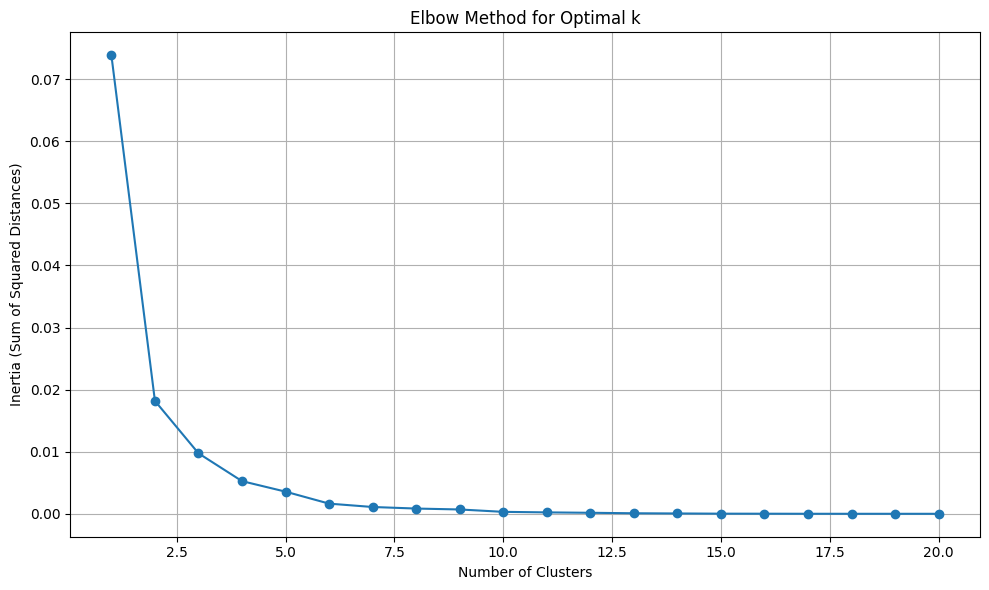

In [352]:
# Initialize an empty list to store the inertia (sum of squared distances)
inertia = []

# Maximum number of clusters to test
max_clusters = 20

# Calculate inertia for different values of k
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(averages)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

Cluster Centers:
[[0.02895691]
 [0.14500182]
 [0.23092564]
 [0.09237826]
 [0.17855001]
 [0.06890971]
 [0.20341316]
 [0.11496105]]

Cluster Labels:
[2 5 5 3 3 7 3 5 0 0 1 1 4 6 2 4 4 1 1 5]
Cluster 0 Indices: [8 9]
Cluster 1 Indices: [10 11 17 18]
Cluster 2 Indices: [ 0 14]
Cluster 3 Indices: [3 4 6]
Cluster 4 Indices: [12 15 16]
Cluster 5 Indices: [ 1  2  7 19]
Cluster 6 Indices: [13]
Cluster 7 Indices: [5]


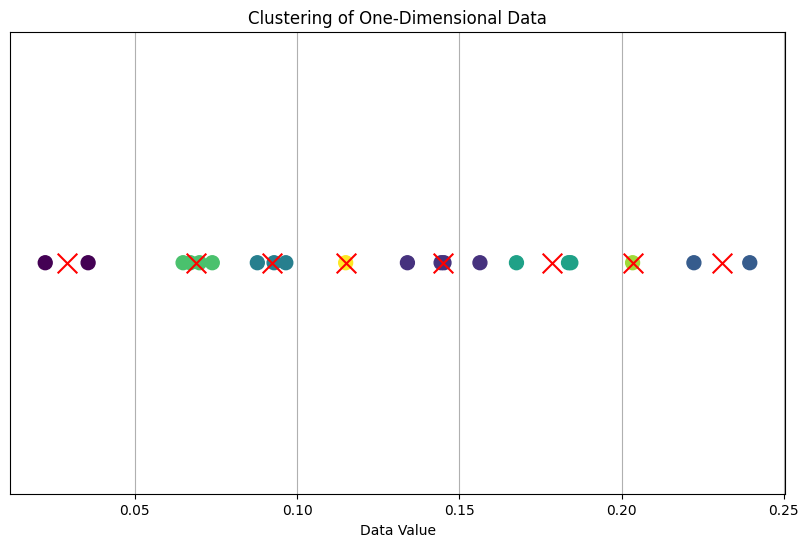

In [353]:

n_clusters = 8

# Initialize KMeans clustering
kmeans = KMeans(n_clusters=n_clusters)

# Fit the model to the data
kmeans.fit(averages)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Print the cluster centers and labels
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("\nCluster Labels:")
print(cluster_labels)

# Initialize lists to store indices for each cluster
cluster_indices = [[] for _ in range(n_clusters)]

# Populate the lists with indices
for idx, label in enumerate(cluster_labels):
    cluster_indices[label].append(idx)

# Convert lists to arrays for each cluster
cluster_indices = [np.array(indices) for indices in cluster_indices]

# Print the indices of elements in each cluster
for i, indices in enumerate(cluster_indices):
    print(f"Cluster {i} Indices: {indices}")
    
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(averages, np.zeros_like(averages), c=cluster_labels, cmap='viridis', s=100)
plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), c='red', s=200, marker='x')
plt.title('Clustering of One-Dimensional Data')
plt.xlabel('Data Value')
plt.yticks([])  # Hide y-axis ticks since this is one-dimensional data
plt.grid(True)
plt.show()

In [354]:
#Write out a .wav file with the components in each cluster combined
k = 0
for i in cluster_indices:
    out = combine_components(comps, acts, i, filename='./idx' + str(k) + '.wav')
    k+=1